In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import jieba as jb
import re
#如果還沒有安裝tensorflow2.0,請使用下面的指令安裝tensorflow
#!pip install tensorflow==2.0.0
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.17.0


# 數據

In [2]:
# #載入google的雲端硬碟
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/text_classfity/data

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/text_classfity/data


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/text_classfity/data/online_shopping_10_cats.csv')
print("數據總量: %d ." % len(df))
df.sample(10)

數據總量: 62774 .


,cat,label,review
57323,酒店,1,每次住的感觉都不错，就是这次被蚊子打扰了，建议加强房间灭蚊
30655,洗发水,1,物流超快，服务也好。实惠！赠品出去旅游超好！
54875,酒店,1,环境十分棒，住着感到特别安全。本人住的是主楼28204房，客房服务人员和前台小姐、门童的态度...
42840,衣服,1,裤子收到了，质量真是不错也不会退色，比我想象中好多了……好评
9855,平板,0,手机是一般般，但是降价未免太快了吧。还没几天又降了200。后悔买了。
14881,手机,1,机子外形不错，只是外屏容易按上手印，内屏6万5千色的，虽然比不了26万的，但是在我看来一样颜...
60179,酒店,0,本人于3月27日凌晨入住此酒店，作为一家三星级酒店，竟然没有热水，而前台服务员明知道却不在入...
48751,衣服,0,没见过这么烂的服务和牛仔裤
58900,酒店,0,"入住了单人间，房间不是非常小，而是只能用“袖珍”来形容,连窗户也没有，房间面积仅仅能够放下一..."
54629,酒店,1,非常不错的一家酒店，硬件软件都是一流的。三个餐厅也都非常不错。咖啡厅的蛋糕到了晚上半价。行李...


### class

In [4]:
df[["cat"]].drop_duplicates().reset_index(drop=True)

,cat
0,书籍
1,平板
2,手机
3,水果
4,洗发水
5,热水器
6,蒙牛
7,衣服
8,计算机
9,酒店


In [5]:
print(df.cat.value_counts())
print()
print(df.cat.value_counts()/len(df));


cat
平板     10000
水果     10000
酒店     10000
洗发水    10000
衣服     10000
计算机     3992
书籍      3851
手机      2323
蒙牛      2033
热水器      575
Name: count, dtype: int64

cat
平板     0.159302
水果     0.159302
酒店     0.159302
洗发水    0.159302
衣服     0.159302
计算机    0.063593
书籍     0.061347
手机     0.037006
蒙牛     0.032386
热水器    0.009160
Name: count, dtype: float64


In [6]:
df[df.cat=='平板'][["review"]].sample(5).values

array([['速度还是很快的，很郁闷的是苹果的一些游戏华为是不能下载的'],
       ['不错挺好，不知道用的久不！'],
       ['另触摸屏敏感度，精确度也有进步空间。'],
       ['垃圾的很啊，卡的要命，后悔买了！待机时间就不用提了！'],
       ['东西太差劲了 我买回来几天也没咋用 等我用的时候才发现老是跳屏 卡一下']], dtype=object)

In [7]:
df[df.cat=='手机'][["review"]].sample(5).values

array([['我是今年刚买的，用到现在已经报废。外屏已坏！内彩屏根本看不见东西。图象完全成花的！待机也就2天。这是我用的多款飞利浦手机里最糟糕的一款。两位同事买了不久也是出现这样那样的问题。PHILIPS已经让我失望。我决定再也不买飞利浦的手机。'],
       ['1.优良的外观设计和做工十分突出2.功能强大实用，侧重娱乐方面3.200万像素摄像头，拍摄选项丰富，操作方式新颖4.独立立体声扬声器设计，音视频播放效果较好5.配件全面丰富'],
       ['闹钟不支持周期选择；不支持蓝牙无线传输；录音时间太短。'],
       ['是彩屏的。而且价钱比较适合学生'],
       ['黑色机总让人感觉很酷，刚刚拿手上用，同事都过来看哦，嘿嘿，拿起来也很轻。按键音挺逗的，以选择东北话，闽南话，上海话，很搞笑，电话每天都用，3天充一次，还行']],
      dtype=object)

In [8]:
df[df.cat=='酒店'][["review"]].sample(5).values

array([['这酒店也就是地理位置好吧，赶早班机的朋友可以住住。在楼道看到服务员询问事情，第一次碰到会两手叉在胸前跟客人说话的。也不问好，态度生硬。这酒店，这服务，算了吧。'],
       ['电梯维修，只能爬楼，房间不大，设施一般。房间里居然连个大灯都没有，只有一盏远远的台灯晃着暗暗的光。最恐怖的是窗户外面就是走廊，隔音基本为零，只要有人走路说话，都会有回音，特响。清晨就有酒店人员穿着拖鞋嘻嘻哈哈的走过，您就别想睡了。'],
       ['离泰山较远，实际环境与价格不符，漂亮的外观，陈旧破烂的内里，隔音极差'],
       ['酒店时间太久，设施都很旧，空调整宿嗡嗡的响。这次最让人不满意的是入住后第二天晚上回到房间，看到房间内酒水消费单上莫名的被记上消费了一瓶35的矿泉水，然后才注意到入住第一天明明什么都没有的门口小桌位置上多了一瓶昆仑山矿泉水！瞬间明白收拾房间的人估计在入住前就没放水，然后一看没有就以为我喝了！！然后就记上账单了，打电话给前台只说让退房时再解决！转天退房果然这条消费记录还在，不在乎这点钱，在乎的是一家老牌五星酒店的服务质量，如果我没注意账单呢，是不是就直接白白被坑了呢！客房人员在客人入住前是不是也应该确认清楚房间内到底有什么东西！不会再入住了！'],
       ['应该算是仪征最好的酒店了，四星的设施，三星的服务。遗憾的是某些设施还并未开放。早餐很一般，连收盘子的服务员也没有，与其四星的标准不符。']],
      dtype=object)

In [9]:
df[df.cat=='衣服'][["review"]].sample(5).values

array([['裤子特别棒，没有色差，料子很舒服。客服也很耐心给我讲解各种问题，果然是做男装的品牌，没买错！全五星好评，以后还会来光顾你家的，也会介绍给身边的朋友！'],
       ['不怎么样，，，，，，，'],
       ['不错 挺好的 很满意的一次购物。'],
       ['号码偏少换了两次还要我出快递费，郁闷'],
       ["这个裤子是非常耐穿的，质量没得说，而且是修身版的''''''可以在冬季穿。"]], dtype=object)

## 資料預處理

下面我們要對評語進行一些預處理工作,這包括刪除文本中的標點符號,特殊符號,還要刪除一些無意義的常用詞(stopword),因為這些詞和符號對系統分析預測文本的內容沒有任何幫助,反而會增加計算的複雜度和增加系統開銷,所有在使用這些文字資料之前必須要將它們清理乾淨。

In [10]:
#定義刪除除字母,數字，漢字以外的所有符號的函數
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line

def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

#載入停用詞
stopwords = stopwordslist("/content/drive/MyDrive/Colab Notebooks/text_classfity/data/cn_stopwords.txt")

中文停用詞包含了很多日常使用頻率很高的常用詞,如 吧，嗎，呢，啥等一些感嘆詞等,這些高頻常用詞無法反應出文本的主要意思,所以要被過濾掉。

In [11]:
df['clean_review'] = df['review'].apply(remove_punctuation)
df.sample(10)

,cat,label,review,clean_review
30066,洗发水,1,哈哈哈，还不错咯，下次再来。哈哈哈,哈哈哈还不错咯下次再来哈哈哈
29753,洗发水,1,洗发水收到了，用了一次很好，快递员特好特快，谢谢,洗发水收到了用了一次很好快递员特好特快谢谢
35607,洗发水,0,产品质量不是很好，不是很满意。,产品质量不是很好不是很满意
13342,平板,0,垃圾中的战斗机 刚买屏幕就坏了,垃圾中的战斗机刚买屏幕就坏了
40231,衣服,1,物有所值，物流很快，质量很不错!,物有所值物流很快质量很不错
2795,书籍,0,虽然是老乡的作品，但是从客观上来讲的话，还是有点牵强，虽然作者的经历很丰富文采也不错，但不太...,虽然是老乡的作品但是从客观上来讲的话还是有点牵强虽然作者的经历很丰富文采也不错但不太喜欢结构...
55853,酒店,1,酒店靠近火车站，交通还算方便。软件方面酒店人员的服务态度不错，任何事情都及时回复。硬件方面优...,酒店靠近火车站交通还算方便软件方面酒店人员的服务态度不错任何事情都及时回复硬件方面优点是房间...
56099,酒店,1,8月份在赛格尔住了几天，住过208元的商务间和238元的豪华单人间，感觉如下：优点：1、地理...,8月份在赛格尔住了几天住过208元的商务间和238元的豪华单人间感觉如下优点1地理位置很好走...
50351,计算机,1,上网本基本性能都是这样，对于仅仅用来上网聊天以及做一些简单办公的人来说还是不错的。在均衡配置...,上网本基本性能都是这样对于仅仅用来上网聊天以及做一些简单办公的人来说还是不错的在均衡配置做工...
20111,水果,1,在京东买鲜果，速度非常快。苹果脆甜，快递非常给力，给十个赞了！,在京东买鲜果速度非常快苹果脆甜快递非常给力给十个赞了


我們過濾掉了review中的標點符號和一些特殊符號，並產生了一個新的欄位 clean_review。接下來我們要在clean_review的基礎上進行分詞,把每個評論內容分成由空格隔開的一個一個單獨的詞語。

In [12]:
#分詞，並過濾停用詞
df['cut_review'] = df['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.379 seconds.
DEBUG:jieba:Loading model cost 1.379 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,cat,label,review,clean_review,cut_review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...,做 父母 一定 刘墉 心态 不断 学习 不断 进步 不断 补充 新鲜血液 保持 一颗 年轻 ...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...,作者 真有 英国人 严谨 风格 提出 观点 进行 论述 论证 物理学 了解 不深 仍然 感受...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...,作者 长篇大论 借用 详细 报告 数据处理 工作 计算结果 支持 其新 观点 荷兰 曾经 县...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...,作者 战 之前 拥抱 令人 叫绝 日本 没有 战败 会 美军 占领 没胡 官僚主义 延续 没...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...,作者 少年 时即 喜 阅读 看出 精读 无数 经典 一个 庞大 内心世界 作品 难能可贵 两...


# 建模

首先我們要資料集中拆分出訓練集和驗證集,我們將80%的資料作為訓練集,20%的資料作為驗證集，我們透過分層抽樣的方式來隨機抽樣，注意在這裡我們使用了sklearn的train_test_split的方法來抽樣,並使用了stratify參數來保證抽樣後,訓練集和驗證集中的各個類目的佔比與原數據集保持一致。

In [13]:
#拆分訓練集和測試集
X_train, X_validation, Y_train, Y_validation = train_test_split(df[['cut_review']],df[["cat"]], test_size = 0.2,stratify=df.cat)
print(len(X_train))
print(len(X_validation))

50219
12555


In [14]:
Y_train.cat.value_counts()/len(Y_train)

,count
cat,
酒店,0.159302
衣服,0.159302
水果,0.159302
平板,0.159302
洗发水,0.159302
计算机,0.063601
书籍,0.061351
手机,0.036998
蒙牛,0.032378


In [15]:
Y_validation.cat.value_counts()/len(Y_validation)

,count
cat,
酒店,0.159299
平板,0.159299
洗发水,0.159299
衣服,0.159299
水果,0.159299
计算机,0.063560
书籍,0.061330
手机,0.037037
蒙牛,0.032417


In [16]:

vocab_size = 5000
embedding_dim = 64
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [17]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.cut_review.values)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [18]:
print(len(list(word_index.items())))
print()
list(word_index.items())[:10]

62632



[('<OOV>', 1),
 ('买', 2),
 ('不错', 3),
 ('没有', 4),
 ('酒店', 5),
 ('京东', 6),
 ('说', 7),
 ('房间', 8),
 ('一个', 9),
 ('非常', 10)]

In [19]:
X_train_sequences = tokenizer.texts_to_sequences(X_train.cut_review.values)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_validation_sequences = tokenizer.texts_to_sequences(X_validation.cut_review.values)
X_validation_padded = pad_sequences(X_validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [20]:
index = 10
print(X_train.cut_review.values[index])
print()
print(X_train_sequences[index])
print()
X_train_padded[index]


价格 贵 一点 还行

[20, 198, 55, 395]



array([ 20, 198,  55, 395,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [21]:
print("104 ->",reverse_word_index[104])
print("3 ->",reverse_word_index[3])
print("120 ->",reverse_word_index[120])
print()
print("贴身 ->",dict(list(word_index.items()))["贴身"])
print("1 ->",reverse_word_index[1])


104 -> 好吃
3 -> 不错
120 -> 找

贴身 -> 7410
1 -> <OOV>


In [22]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df.cat.values)

Y_training_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_train.cat.values))
Y_validation_cat_seq = np.array(label_tokenizer.texts_to_sequences(Y_validation.cat.values))

label_word_index = label_tokenizer.word_index

print(dict(list(label_word_index.items())))
print(Y_training_cat_seq.shape)
print()
print(Y_training_cat_seq[0])
print(Y_training_cat_seq[1])
print(Y_training_cat_seq[2])


{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
(50219, 1)

[6]
[5]
[4]


In [23]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X_train_padded[0]))
print('------------------------------------------------')
print(X_train.cut_review.values[0])

ibm 老 用户 t 系列 爱 有个 <OOV> <OOV> 设计 用料 t 系列 <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
------------------------------------------------
IBM 老 用户 T 系列 爱 有个 LENOVO 标记 设计 用料 T 系列 一贯作风


In [24]:
model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
num_epochs = 10
history = model.fit(X_train_padded,
                    Y_training_cat_seq,
                    epochs=num_epochs,
                    validation_data=(X_validation_padded, Y_validation_cat_seq),
                    verbose=2)

Epoch 1/10
1570/1570 - 27s - 17ms/step - accuracy: 0.7844 - loss: 0.6281 - val_accuracy: 0.8749 - val_loss: 0.3650
Epoch 2/10
1570/1570 - 22s - 14ms/step - accuracy: 0.8943 - loss: 0.3090 - val_accuracy: 0.8761 - val_loss: 0.3556
Epoch 3/10
1570/1570 - 40s - 26ms/step - accuracy: 0.9139 - loss: 0.2447 - val_accuracy: 0.8818 - val_loss: 0.3459
Epoch 4/10
1570/1570 - 20s - 13ms/step - accuracy: 0.9238 - loss: 0.2137 - val_accuracy: 0.8796 - val_loss: 0.3596
Epoch 5/10
1570/1570 - 21s - 14ms/step - accuracy: 0.9316 - loss: 0.1889 - val_accuracy: 0.8775 - val_loss: 0.3715
Epoch 6/10
1570/1570 - 41s - 26ms/step - accuracy: 0.9387 - loss: 0.1682 - val_accuracy: 0.8804 - val_loss: 0.3859
Epoch 7/10
1570/1570 - 41s - 26ms/step - accuracy: 0.9447 - loss: 0.1528 - val_accuracy: 0.8760 - val_loss: 0.4124
Epoch 8/10
1570/1570 - 41s - 26ms/step - accuracy: 0.9500 - loss: 0.1385 - val_accuracy: 0.8755 - val_loss: 0.4692
Epoch 9/10
1570/1570 - 41s - 26ms/step - accuracy: 0.9527 - loss: 0.1290 - val_a

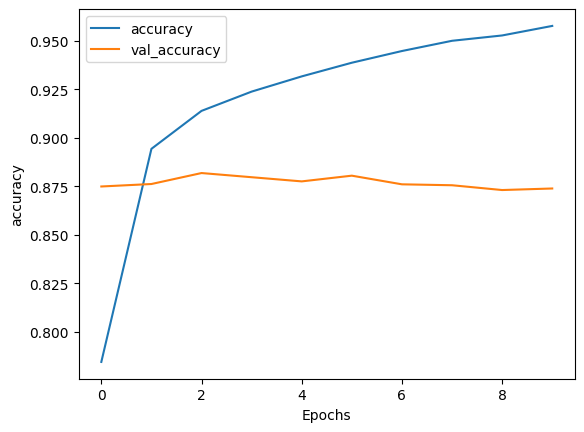

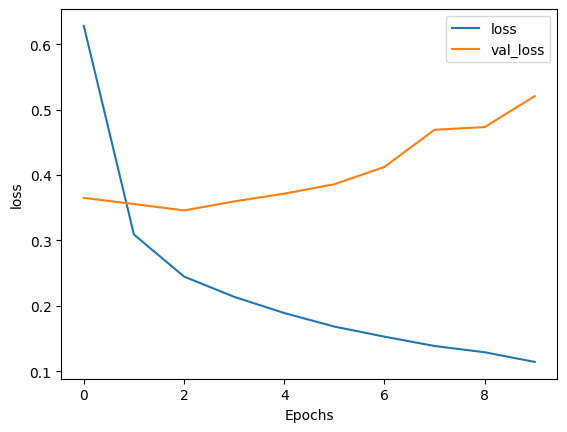

In [27]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = model.predict(X_validation_padded)
y_pred = y_pred.argmax(axis = 1)


393/393 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}


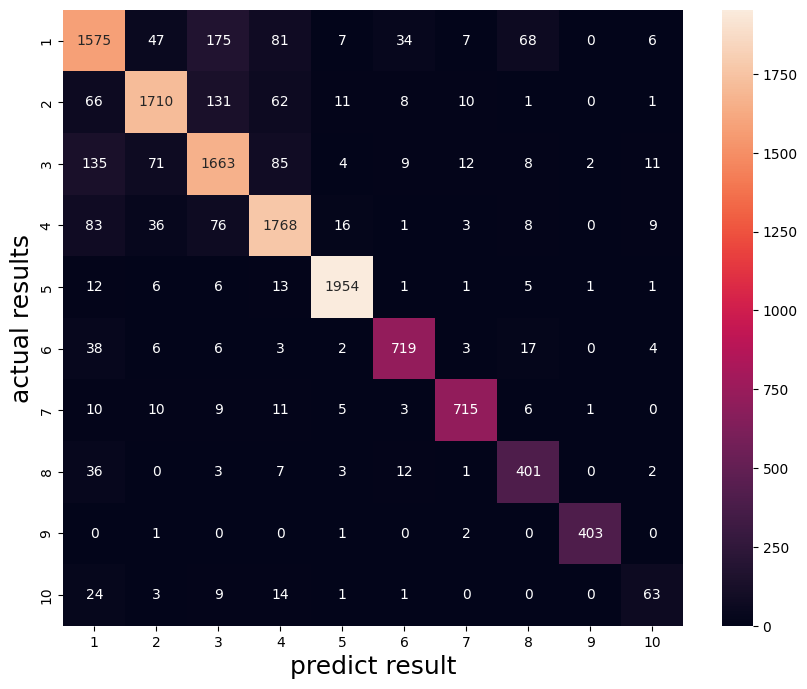

In [29]:
labels=[1,2,3,4,5,6,7,8,9,10]
conf_mat = confusion_matrix(Y_validation_cat_seq, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel('actual results',fontsize=18);
plt.xlabel('predict result',fontsize=18);
print(dict(list(label_word_index.items())))



In [30]:
from  sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, Y_validation_cat_seq))
print(classification_report(Y_validation_cat_seq, y_pred,target_names=[str(w) for w in labels]))
print(dict(list(label_word_index.items())))

accuracy 0.8738351254480287
              precision    recall  f1-score   support

           1       0.80      0.79      0.79      2000
           2       0.90      0.85      0.88      2000
           3       0.80      0.83      0.82      2000
           4       0.86      0.88      0.87      2000
           5       0.98      0.98      0.98      2000
           6       0.91      0.90      0.91       798
           7       0.95      0.93      0.94       770
           8       0.78      0.86      0.82       465
           9       0.99      0.99      0.99       407
          10       0.65      0.55      0.59       115

    accuracy                           0.87     12555
   macro avg       0.86      0.86      0.86     12555
weighted avg       0.87      0.87      0.87     12555

{'平板': 1, '水果': 2, '洗发水': 3, '衣服': 4, '酒店': 5, '计算机': 6, '书籍': 7, '手机': 8, '蒙牛': 9, '热水器': 10}
